# Parsing data from twitter

- Getting counts within time ranges.
- Creating a time_ranges_with_timeperiod dataframe, that contains rows labeled with timeperiod based on tweet count thresholds.
- Collecting tweets within detected time ranges.
- Retreiving information on users whose tweets are collected.
- Merging tweets and infirmation on users and saving into file balenciaga_scarped.pkl.

# Libraries to import

In [3]:
import tweepy
import json
import pandas as pd
from tqdm.auto import tqdm
import time
import requests
import matplotlib.pyplot as plt

/Users/deryadurmush/.pyenv/versions/migration1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Twitter tokens
Hided tokens for security measures.

In [1]:
at = ''
ats = ''
bt = ''

api_key = ''
api_secret_key = ''
access_token = ''
access_token_secret = ''

In [ ]:
def initialize_client():
    return tweepy.Client(bearer_token=bt)

# Scarping time ranges for tweets parsing

In [ ]:
def fetch_tweet_counts(client, search_query, pairs_arr, granularity='minute', wait_time=900):
    """
    Fetches tweet counts for a single search query within specified time ranges.

    Parameters:
        client (tweepy.Client): Authenticated Tweepy client instance.
        search_query (str): The search query (string).
        pairs_arr (pd.DataFrame): DataFrame with 'start' and 'end' columns for time ranges.
        granularity (str): Granularity for tweet counts ('minute', 'hour', 'day').
        wait_time (int): Time to wait (in seconds) before retrying after an API rate limit error.

    Returns:
        pd.DataFrame: Combined DataFrame with tweet counts for the search query and time ranges.
    """
    total_tweet_count = 0
    dataframes = []

    for i in range(pairs_arr.shape[0]):
        start_time = pairs_arr['start'][i]
        end_time = pairs_arr['end'][i]

        try:
            tweets = client.get_all_tweets_count(
                query=search_query,
                start_time=start_time,
                end_time=end_time,
                granularity=granularity
            )

            df = pd.DataFrame(tweets.data)
            df['search_query'] = search_query

            print(f"{search_query}: {df['tweet_count'].sum()} tweets")
            total_tweet_count += df['tweet_count'].sum()
            dataframes.append(df)

        except Exception as e:
            print(f"Error: {e}. Entering waiting mode...")
            time.sleep(wait_time)
            tweets = client.get_all_tweets_count(
                query=search_query,
                start_time=start_time,
                end_time=end_time,
                granularity=granularity
            )
            df = pd.DataFrame(tweets.data)
            total_tweet_count += df['tweet_count'].sum()
            dataframes.append(df)
    result_df = pd.concat(dataframes, axis=0)
    
    return result_df


In [ ]:
client = initialize_client()

search_query = 'balenciaga'
dates = [str(i)[:-9] + 'T00:00:00Z' for i in pd.date_range(start='11/01/2022', periods=163)]
pairs_arr = pd.DataFrame({'start':dates[:-1], 'end':dates[1:]})

time_ranges = fetch_tweet_counts(client, search_query, pairs_arr)

In [39]:
dates = [str(i)[:-9] + 'T00:00:00Z' for i in pd.date_range(start='11/01/2022', periods=163)]
pairs_arr = pd.DataFrame({'start':dates[:-1], 'end':dates[1:]})


Creating time_ranges_with_timeperiod dataframe, that contains rows labeled with timeperiod based on tweet count thresholds.

- timeperiod = 1: Marks rows with cumulative tweet counts exceeding 450 or adjacent to rows exceeding the threshold.
- timeperiod = 2: Marks rows with isolated large jumps in cumulative counts.

In [ ]:
df_local = time_ranges.copy().reset_index(drop=True)

counter = 0
counter2 = 0

for i in tqdm(range(1, df_local.shape[0]), desc="Assigning time periods"):
    counter2 += df_local['tweet_count'][i]

    if df_local['tweet_count'][i] >= 450:
        if df_local['tweet_count'][i - 1] < 450:
            df_local.at[i - 1, 'timeperiod'] = 1
        df_local.at[i, 'timeperiod'] = 1
        counter = 0
        counter2 = 0
    elif counter2 >= 450 and 0 < counter < 450:
        df_local.at[i - 1, 'timeperiod'] = 1
        counter = df_local['tweet_count'][i]
        counter2 = df_local['tweet_count'][i]
    elif counter2 < 450 and counter < 450:
        counter += df_local['tweet_count'][i]
    elif counter == 0 and counter2 > 450:
        df_local.at[i, 'timeperiod'] = 2
        counter = 0
        counter2 = 0

time_ranges_with_timeperiod = df_local.reset_index(drop=True)

No rows have timeperiod = 2, indicating there were no isolated spikes or non-contiguous periods where cumulative tweet counts exceeded 450.

In [231]:
time_ranges_with_timeperiod[time_ranges_with_timeperiod['timeperiod'] == 2]

,end,start,tweet_count,search_query,timeperiod


Retrieves tweets within time periods scarped 

In [ ]:
def extract_geo(geo_data):
    try:
        return geo_data['place_id']
    except (TypeError, KeyError):
        return None


def fetch_tweets(client, query, start_time, end_time):
    return client.search_all_tweets(
        query=query,
        start_time=start_time,
        end_time=end_time,
        tweet_fields=["created_at", "text", "source", 'author_id', 'public_metrics', 'geo', 'entities', 'lang'],
        user_fields=["name", "username", "location", "verified", "description"],
        place_fields=['full_name', 'id', 'country', 'country_code', 'geo', 'name', 'place_type'],
        max_results=500,
        expansions=['author_id', 'geo.place_id']
    )


def process_tweets(tweets, search_query):
    tweet_data = []
    for tweet in tweets.data:
        tweet_data.append([
            tweet.id, tweet.text, tweet.author_id, extract_geo(tweet.geo), tweet.created_at,
            tweet.lang, tweet.public_metrics.get('retweet_count', 0), tweet.public_metrics.get('reply_count', 0),
            tweet.public_metrics.get('like_count', 0), tweet.public_metrics.get('quote_count', 0)
        ])
    df = pd.DataFrame(tweet_data, columns=[
        'tweet_id', 'text', 'author_id', 'geo', 'created_at', 'lang',
        'retweet_count', 'reply_count', 'like_count', 'quote_count'
    ])
    df['author_location'] = '-1'
    df['country'] = 'No Country'
    df['query'] = search_query
    return df


def fetch_all_tweets(time_ranges):
    tweets_list = []
    client = initialize_client()
    request_counter = 0

    for i in tqdm(range(time_ranges.shape[0]), desc="Fetching tweets"):
        query = time_ranges['search_query'][i]
        start_time = time_ranges['start'][i]
        end_time = time_ranges['end'][i]

        try:
            tweets = fetch_tweets(client, query, start_time, end_time)
        except Exception:
            time.sleep(5)
            tweets = fetch_tweets(client, query, start_time, end_time)

        request_counter += 1
        if request_counter == 290:
            time.sleep(900)
            request_counter = 0

        if tweets.meta['result_count'] > 0:
            print(f"Found {tweets.meta['result_count']} tweets for query '{query}'")
            df = process_tweets(tweets, query)
            tweets_list.append(df)

        time.sleep(1)

    return pd.concat(tweets_list, axis=0) if tweets_list else pd.DataFrame()

time_ranges = pd.DataFrame({
    'search_query': ['balenciaga'], 
    'start': [pairs_arr['start'].min()], 
    'end': [pairs_arr['end'].max()]
})

tweets = fetch_all_tweets(time_ranges)


Retriving user's information

In [262]:
users_from_tweets = tweets['author_id'].unique()
users = pd.DataFrame({'author_id':users_from_tweets})
users

,author_id
0,1123166102995865600
1,1950852385
2,50073553
3,1388702657792159746
4,49987009
...,...
58067,198146259
58068,704059993
58069,1526758613775155200
58070,1235772718043316226


In [ ]:
headers = {
    'Authorization': f"Bearer {bt}",
}

profile_arr = []
counter = 0

for i in tqdm(range(users.shape[0] // 100 + 1)):
    if counter == 295:
        time.sleep(900)
        counter = 0
        
    author_ids = ','.join([str(i) for i in users.iloc[i * 100:(i+1)*100, :]['author_id'].tolist()])
    s = f"https://api.twitter.com/2/users?ids={author_ids}&user.fields=location,name"
    response = requests.get(s, headers=headers)
    r = json.loads(response.text)['data']
    profile_arr.append(pd.DataFrame(r))
    counter += 1

In [264]:
users = pd.concat(profile_arr, axis = 0).reset_index(drop=True)
users = users.drop(columns = ['withheld']).drop_duplicates().reset_index(drop=True)
users['loc1'] = users['location'].str.lower().fillna('no country')
users['country'] = 'no country'
users['id'] = users['id'].apply(int)

Merging user's information and tweets

In [ ]:
combined_df = tweets.merge(users.rename(columns = {"id":'author_id'}), how = 'left', on = 'author_id')
combined_df.to_pickle('balenciaga_scarped.pkl')

Check of data

In [35]:
df = pd.read_pickle('/Users/deryadurmush/Desktop/Jobs /balenciaga/balenciaga_scarped.pkl')
df.shape

(2408492, 19)

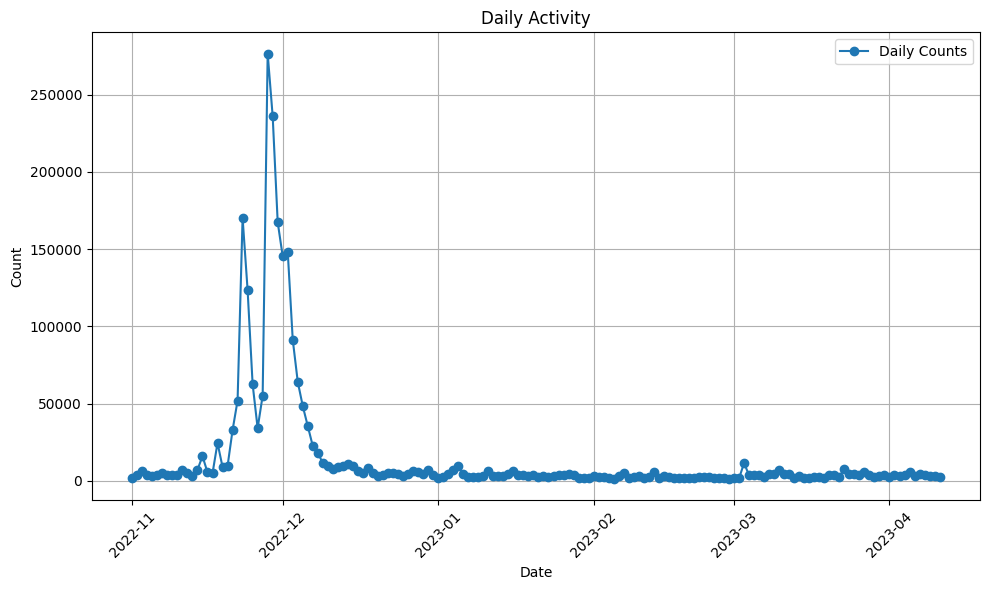

In [36]:
df['timestamp'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)

df['date'] = df['timestamp'].dt.date
daily_counts = df['date'].value_counts().sort_index()


plt.figure(figsize=(10, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', label='Daily Counts')
plt.title('Daily Activity')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
